# Do you need psuedo labels?

# You might need a token for space itself? start and stop tokens?

# Sentiment Classification model with test as well in train? Will increase the vocab size as well?

# * https://www.tensorflow.org/tutorials/text/transformer
# * https://pytorch.org/tutorials/beginner/transformer_tutorial.html

## Settings

In [49]:
# CONTROLS
MODEL_PREFIX = "V09"
MODEL_NUMBER = MODEL_PREFIX[-2:]
TRAIN_SPLIT_RATIO = 0.8

DROPOUT = 0.1
MIN_LR = 1e-5
MAX_LR = 1e-2
BATCH_SIZE = 1024
PREDICT_BATCH_SIZE = 2048
STEP_SIZE = 10
CLR_METHOD = "triangular" # exp_range, triangular, triangular2
NUM_EPOCHS = 60

## Libraries

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

#from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight

import pickle, os, sys, re

import spacy
from spacy.lang.en import English

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv1D, Conv2D, LSTM, Embedding, Dense, concatenate, MaxPooling2D, Softmax, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Reshape, Activation, Bidirectional, TimeDistributed
from tensorflow.keras.layers import RepeatVector, Multiply
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

%matplotlib inline

In [3]:
from tensorflow.keras.callbacks import *
import tensorflow.keras.backend as K

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [4]:
pd.set_option('display.max_colwidth', -1)
np.random.seed(54321)

c:\users\deepak\miniconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


## Import Data

In [5]:
df = pd.read_csv("../data/train.csv",
                 dtype={"time":np.float64,"signal":np.float64,"open_channels":np.int16},
                 encoding="utf8")

df2 = pd.read_csv("../data/train.csv",
                 dtype={"time":np.float64,"signal":np.float64,"open_channels":np.int16})

print(pd.concat((df.dtypes, df.isna().sum()), axis=1))
print(df.shape)

# Counts of various columns
print({i:df[i].nunique() for i in df.columns})
print(df.describe()) #.astype(int)
df.head(2)

                    0  1
textID         object  0
text           object  1
selected_text  object  1
sentiment      object  0
(27481, 4)
{'textID': 27481, 'text': 27480, 'selected_text': 22463, 'sentiment': 3}
            textID  \
count   27481        
unique  27481        
top     3587b03d9f   
freq    1            

                                                                           text  \
count   27480                                                                     
unique  27480                                                                     
top     is new to twitter and has no friends here... or should i say followers?   
freq    1                                                                         

       selected_text sentiment  
count   27480         27481     
unique  22463         3         
top     good          neutral   
freq    199           11118     


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative


In [6]:
test_df = pd.read_csv("../data/test.csv", dtype={"time":np.float64,"signal":np.float64})
print(pd.concat((test_df.dtypes, test_df.isna().sum()), axis=1))
print(test_df.shape)

# Counts of various columns
print({i:test_df[i].nunique() for i in test_df.columns})
print(test_df.describe())
test_df.head(2)

                0  1
textID     object  0
text       object  0
sentiment  object  0
(3534, 3)
{'textID': 3534, 'text': 3534, 'sentiment': 3}
            textID  \
count   3534         
unique  3534         
top     416726e6d2   
freq    1            

                                                                                     text  \
count   3534                                                                                
unique  3534                                                                                
top      go to mid valley la ****  haha! never mind la, i don`t wanna go with you anyways   
freq    1                                                                                   

       sentiment  
count   3534      
unique  3         
top     neutral   
freq    1430      


,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China: (SH) (BJ).,positive


In [7]:
df.loc[df2['text'].astype('str').apply(lambda x : len(re.findall(pattern="ï¿½", string=x))>0)].head(2)

,textID,text,selected_text,sentiment
44,c77717b103,I love to! But I`m only available from 5pm. and where dear? Would love to help convert her vids.ï¿½,I love to!,positive
192,28dbada620,*phew* Will make a note in case anyone else runs into the same issueï¿½,*phew* Will make a note in case anyone else runs into the same issueï¿½,neutral


In [8]:
test_df.loc[test_df['text'].astype('str').apply(lambda x : len(re.findall(pattern="ï¿½", string=x))>0)].head(2)

,textID,text,sentiment
145,7223fdccc2,tikcets are only ï¿½91...each...BUT I SO WANT TO GO,positive
618,43ad351369,"AHHH - Whatchu talkinï¿½ baby? HAHAHA I canï¿½t believe youu:O heh, actually I can. Life is worth taking risks... http://tumblr.com/xs81qy54s",positive


## Exploration

#### Sentiment count in training

In [9]:
pd.concat([df.groupby("sentiment")[["text"]].count(), test_df.groupby("sentiment")[["text"]].count()], axis=1)

,text,text
sentiment,,
negative,7781,1001
neutral,11117,1430
positive,8582,1103


## Preprocessing

#### Cleaning

In [10]:
# For traceability
df["original_index"] = df.index
test_df["original_index"] = test_df.index

In [11]:
print(df.shape)
df = df[(~df.text.isna())]
df = df.reset_index(drop=True)
df = df.copy()
print(df.shape)

(27481, 5)
(27480, 5)


In [12]:
df["sentiment_code"] = df["sentiment"].astype("category")
X_sentiments = df["sentiment_code"].cat.codes.values

test_df["sentiment_code"] = test_df["sentiment"].astype("category")
X_sentiments_test = test_df["sentiment_code"].cat.codes.values

In [13]:
df["text"] = df["text"].astype(str)
df["selected_text"] = df["selected_text"].astype(str)
test_df["text"] = test_df["text"].astype(str)

#### Tagging

In [14]:
def preprocess_text(x, extra_string=None):
    x = x.lower()
    x = re.sub('([!"#$%&()*+,-./:;\'<=>?@[\\]^_{|}~\t\n])', ' \\1 ', x) # Not including ` here since used in couldn`t, isn`t
    x = x.strip()
    x = re.sub(' +', ' ', x)
    x = x.split(" ")
    if extra_string is not None:
        x = ["xxxSTART"] + x + ["xxxSENTIMENT"] + [extra_string] + ["xxxEND"]
    return x

In [15]:
def get_extremities(l_string, s_string, extra_string, print_it=False):
    l_string = preprocess_text(l_string, extra_string)
    s_string = preprocess_text(s_string, extra_string=None)
    
    len_l = len(l_string)
    len_s = len(s_string)
    
    for i in range(len_l - len_s + 1):
        if (i + len_s) <= len_l:
            substring = l_string[i:i+len_s]
            if substring == s_string:
                if print_it:
                    print(l_string)
                    print(substring)
                    print(i, i+len_s, substring)
                
                start_vector, end_vector = np.zeros(len_l, dtype=np.int16), np.zeros(len_l, dtype=np.int16)
                att_vector = np.ones(len_l, dtype=np.int16)
                start_vector[i], end_vector[i+len_s-1] = 1, 1
                
                return (l_string, s_string, start_vector, end_vector, att_vector)

In [16]:
idx = 100
get_extremities(df.text[idx], df.selected_text[idx], df.sentiment[idx], print_it=False)

(['xxxSTART',
  '4am',
  '.',
  'and',
  'im',
  'on',
  'the',
  'beach',
  '.',
  'pretty',
  'xxxSENTIMENT',
  'positive',
  'xxxEND'],
 ['pretty'],
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int16),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int16),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int16))

In [17]:
df[["text_mod", "selected_text_mod", "target_start", "target_stop", "target_atten"]] = df.apply(lambda x: get_extremities(x.text, x.selected_text, x.sentiment), axis=1).apply(pd.Series)
test_df[["text_mod"]] = test_df.apply(lambda x: [preprocess_text(x.text, extra_string = x.sentiment)], axis=1).apply(pd.Series)

In [18]:
df.isna().sum()

textID               0   
text                 0   
selected_text        0   
sentiment            0   
original_index       0   
sentiment_code       0   
text_mod             1476
selected_text_mod    1476
target_start         1476
target_stop          1476
target_atten         1476
dtype: int64

In [19]:
test_df.isna().sum()

textID            0
text              0
sentiment         0
original_index    0
sentiment_code    0
text_mod          0
dtype: int64

In [20]:
df.head(2)

,textID,text,selected_text,sentiment,original_index,sentiment_code,text_mod,selected_text_mod,target_start,target_stop,target_atten
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,0,neutral,"[xxxSTART, i`d, have, responded, ,, if, i, were, going, xxxSENTIMENT, neutral, xxxEND]","[i`d, have, responded, ,, if, i, were, going]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,1,negative,"[xxxSTART, sooo, sad, i, will, miss, you, here, in, san, diego, !, !, !, xxxSENTIMENT, negative, xxxEND]","[sooo, sad]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


In [21]:
df.iloc[df.loc[df['target_start'].isna()].index].head(2)

,textID,text,selected_text,sentiment,original_index,sentiment_code,text_mod,selected_text_mod,target_start,target_stop,target_atten
18,af3fed7fc3,is back home now gonna miss every one,onna,negative,18,negative,NaN,NaN,NaN,NaN,NaN
32,1c31703aef,If it is any consolation I got my BMI tested hahaha it says I am obesed well so much for being unhappy for about 10 minutes.,well so much for being unhappy for about 10 minute,negative,32,negative,NaN,NaN,NaN,NaN,NaN


In [22]:
test_df.head(2)

,textID,text,sentiment,original_index,sentiment_code,text_mod
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,0,neutral,"[xxxSTART, last, session, of, the, day, http, :, /, /, twitpic, ., com, /, 67ezh, xxxSENTIMENT, neutral, xxxEND]"
1,96d74cb729,Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China: (SH) (BJ).,positive,1,positive,"[xxxSTART, shanghai, is, also, really, exciting, (, precisely, -, -, skyscrapers, galore, ), ., good, tweeps, in, china, :, (, sh, ), (, bj, ), ., xxxSENTIMENT, positive, xxxEND]"


In [23]:
anomalous_idxs = df.loc[df['target_start'].isna()].index.tolist()

In [24]:
print(df.shape)
df = df[~df.index.isin(anomalous_idxs)]
df = df.reset_index(drop=True)
df = df.copy()
print(df.shape)

(27480, 11)
(26004, 11)


#### Tokenization

In [25]:
X_words = df['text_mod'].apply(lambda x:list(x)).tolist()
X_att = df['target_atten'].apply(lambda x:list(x)).tolist()

X_words_test = test_df['text_mod'].apply(lambda x:list(x)).tolist()
X_att_test = [[1 for j in i] for i in X_words_test]

Y_words = df['selected_text_mod'].apply(lambda x:list(x)).tolist()
Y_starts = df['target_start'].apply(lambda x:list(x)).tolist()
Y_stops = df['target_stop'].apply(lambda x:list(x)).tolist()

print("\n",
    "X_words:","\t", len(X_words),"\n",
    "X_att:","\t", len(X_att),"\n",
    "Y_words:","\t", len(Y_words),"\n",
    "Y_starts:","\t", len(Y_starts),"\n",
    "Y_stops:","\t", len(Y_stops),"\n",
    "X_words_test:","\t", len(X_words_test),"\n",
    "X_att_test:","\t", len(X_att_test),"\n"
)


 X_words: 	 26004 
 X_att: 	 26004 
 Y_words: 	 26004 
 Y_starts: 	 26004 
 Y_stops: 	 26004 
 X_words_test: 	 3534 
 X_att_test: 	 3534 



In [26]:
print(sum([len(i)==len(j) for i,j in zip(X_att_test, X_words_test)]))
print(sum([len(i)==len(j) for i,j in zip(X_att, X_words)]))

3534
26004


In [27]:
from collections import Counter
word_counts = Counter([j for i in X_words for j in i])

X_unique_tokens = len(word_counts)
word_counts.most_common(10)

[('.', 33619),
 ('xxxSTART', 26004),
 ('xxxSENTIMENT', 26004),
 ('xxxEND', 26004),
 ('!', 14379),
 ('i', 12615),
 ('neutral', 10941),
 ('to', 9447),
 ('the', 8445),
 (',', 7984)]

In [28]:
MIN_WORD_FREQ = 2

In [29]:
word_subset = [i for i,j in word_counts.items() if j >= MIN_WORD_FREQ]
print("VOCAB reduced from", len(word_counts), "to", len(word_subset))

VOCAB reduced from 25847 to 10178


In [30]:
#list_of_words = set(sorted([j for i in X_words for j in i]))
#Y_list_of_words = set(sorted([j for i in Y_words for j in i]))

In [31]:
vocab_itos = {i+2:j for i,j in enumerate(word_subset)}
vocab_stoi = {j:i+2 for i,j in enumerate(word_subset)}

vocab_stoi["xxxUNK"] = 1
vocab_itos[1] = "xxxUNK"

vocab_stoi["xxxNone"] = 0
vocab_itos[0] = "xxxNone"

In [32]:
def get_from_vocab(vocab, word):
    try:
        value = vocab[word]
    except KeyError as k:
        value = vocab_stoi["xxxUNK"]
    return value

In [33]:
X = [[get_from_vocab(vocab_stoi,j) for j in i] for i in X_words]
Y = [[get_from_vocab(vocab_stoi,j) for j in i] for i in Y_words]
X_test = [[get_from_vocab(vocab_stoi,j) for j in i] for i in X_words_test]

In [34]:
max_len = max([len(i) for i in X])
VOCAB_SIZE = len(vocab_stoi)
print(VOCAB_SIZE, max_len)

10180 110


#### Train Validation  split

In [35]:
idx = [i for i in np.arange(len(Y))]
np.random.shuffle(idx)
train_idx, val_idx = idx[:round(TRAIN_SPLIT_RATIO*len(Y))], idx[round(TRAIN_SPLIT_RATIO * len(Y)):]

print(len(idx), len(train_idx), len(val_idx), len(train_idx) + len(val_idx))

26004 20803 5201 26004


In [36]:
X_train, X_val = [X[i] for i in train_idx], [X[i] for i in val_idx]
X_att_train, X_att_val = [X_att[i] for i in train_idx], [X_att[i] for i in val_idx]

Y_train, Y_val = [Y[i] for i in train_idx], [Y[i] for i in val_idx]
Y_starts_train, Y_starts_val = [Y_starts[i] for i in train_idx], [Y_starts[i] for i in val_idx]
Y_stops_train, Y_stops_val = [Y_stops[i] for i in train_idx], [Y_stops[i] for i in val_idx]

print("\n",
    len(X_train),"\t",": X_train","\n",
    len(X_att_train),"\t",": X_att_train","\n",
    len(Y_train),"\t",": Y_train","\n",
    len(Y_starts_train),"\t",": Y_starts_train","\n",
    len(Y_stops_train),"\t",": Y_stops_train","\n",
    len(X_val),"\t",": X_val","\n",
    len(X_att_val),"\t",": X_att_val","\n",
    len(Y_val),"\t",": Y_val","\n",
    len(Y_starts_val),"\t",": Y_starts_val","\n",
    len(Y_stops_val),"\t",": Y_stops_val","\n"
)


 20803 	 : X_train 
 20803 	 : X_att_train 
 20803 	 : Y_train 
 20803 	 : Y_starts_train 
 20803 	 : Y_stops_train 
 5201 	 : X_val 
 5201 	 : X_att_val 
 5201 	 : Y_val 
 5201 	 : Y_starts_val 
 5201 	 : Y_stops_val 



#### Padding

In [37]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [38]:
X_train = pad_sequences(X_train, maxlen=max_len, padding="post")
X_att_train = pad_sequences(X_att_train, maxlen=max_len, padding="post")
Y_train = pad_sequences(Y_train, maxlen=max_len, padding="post")
Y_starts_train = pad_sequences(Y_starts_train, maxlen=max_len, padding="post")
Y_stops_train = pad_sequences(Y_stops_train, maxlen=max_len, padding="post")

X_val = pad_sequences(X_val, maxlen=max_len, padding="post")
X_att_val = pad_sequences(X_att_val, maxlen=max_len, padding="post")
Y_val = pad_sequences(Y_val, maxlen=max_len, padding="post")
Y_starts_val = pad_sequences(Y_starts_val, maxlen=max_len, padding="post")
Y_stops_val = pad_sequences(Y_stops_val, maxlen=max_len, padding="post")

X_test = pad_sequences(X_test, maxlen=max_len, padding="post")
X_att_test = pad_sequences(X_att_test, maxlen=max_len, padding="post")

In [39]:
print("\n",
     X_train.shape, "\t: X_train ", "\n",
     X_att_train.shape, "\t: X_att_train ", "\n",
     Y_train.shape, "\t: Y_train ", "\n",
     Y_starts_train.shape, "\t: Y_starts_train ", "\n",
     Y_stops_train.shape, "\t: Y_stops_train ", "\n",

     X_val.shape, "\t: X_val ", "\n",
     X_att_val.shape, "\t: X_att_val ", "\n",
     Y_val.shape, "\t: Y_val ", "\n",
     Y_starts_val.shape, "\t: Y_starts_val ", "\n",
     Y_stops_val.shape, "\t: Y_stops_val ", "\n",

     X_test.shape, "\t: X_test ", "\n",
     X_att_test.shape, "\t: X_att_test ", "\n"
)


 (20803, 110) 	: X_train  
 (20803, 110) 	: X_att_train  
 (20803, 110) 	: Y_train  
 (20803, 110) 	: Y_starts_train  
 (20803, 110) 	: Y_stops_train  
 (5201, 110) 	: X_val  
 (5201, 110) 	: X_att_val  
 (5201, 110) 	: Y_val  
 (5201, 110) 	: Y_starts_val  
 (5201, 110) 	: Y_stops_val  
 (3534, 110) 	: X_test  
 (3534, 110) 	: X_att_test  



#### Checking for zero input vectors

In [40]:
print(np.argmax([X_train.sum(axis=1)==0]), np.min([X_train.sum(axis=1)]))
print(np.argmax([X_val.sum(axis=1)==0]), np.min([X_val.sum(axis=1)]))

0 36
0 36


#### Check inputs and outputs

In [41]:
#Train
num = 100
[[i,j,k,l,m] for i,j,k,l,m in zip(X_train[num],
                                  X_att_train[num],
                                  Y_train[num],
                                  Y_starts_train[num],
                                  Y_stops_train[num])]

[[2, 1, 1662, 0, 0],
 [87, 1, 648, 0, 0],
 [17, 1, 2533, 0, 0],
 [2174, 1, 7, 0, 0],
 [669, 1, 1685, 0, 0],
 [84, 1, 278, 0, 0],
 [1662, 1, 17, 1, 0],
 [648, 1, 229, 0, 0],
 [2533, 1, 4625, 0, 0],
 [7, 1, 116, 0, 0],
 [1685, 1, 44, 0, 0],
 [278, 1, 406, 0, 0],
 [17, 1, 8227, 0, 0],
 [229, 1, 0, 0, 0],
 [4625, 1, 0, 0, 0],
 [116, 1, 0, 0, 0],
 [44, 1, 0, 0, 0],
 [406, 1, 0, 0, 0],
 [8227, 1, 0, 0, 1],
 [7492, 1, 0, 0, 0],
 [10, 1, 0, 0, 0],
 [11, 1, 0, 0, 0],
 [12, 1, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 

In [42]:
#Val
num = 100
[[i,j,k,l,m] for i,j,k,l,m in zip(X_val[num],
                                  X_att_val[num],
                                  Y_val[num],
                                  Y_starts_val[num],
                                  Y_stops_val[num])]

[[2, 1, 9890, 0, 0],
 [9890, 1, 8753, 1, 0],
 [8753, 1, 55, 0, 0],
 [55, 1, 4465, 0, 0],
 [4465, 1, 305, 0, 0],
 [305, 1, 1, 0, 0],
 [1, 1, 28, 0, 0],
 [28, 1, 0, 0, 1],
 [47, 1, 0, 0, 0],
 [48, 1, 0, 0, 0],
 [49, 1, 0, 0, 0],
 [49, 1, 0, 0, 0],
 [50, 1, 0, 0, 0],
 [28, 1, 0, 0, 0],
 [1, 1, 0, 0, 0],
 [28, 1, 0, 0, 0],
 [51, 1, 0, 0, 0],
 [49, 1, 0, 0, 0],
 [1, 1, 0, 0, 0],
 [49, 1, 0, 0, 0],
 [9890, 1, 0, 0, 0],
 [28, 1, 0, 0, 0],
 [7327, 1, 0, 0, 0],
 [10, 1, 0, 0, 0],
 [11, 1, 0, 0, 0],
 [12, 1, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],


In [43]:
#Test
num = 100
[[i,j,k] for i,j,k in zip(X_words_test[num],
                          X_test[num],
                          X_att_test[num])]

[['xxxSTART', 2, 1],
 ['oooh', 3482, 1],
 [',', 5, 1],
 ['sunshine', 1726, 1],
 ['!', 22, 1],
 ['a', 142, 1],
 ['patch', 905, 1],
 ['of', 34, 1],
 ['sunshine', 1726, 1],
 ['!', 22, 1],
 ['and', 68, 1],
 ['it', 144, 1],
 ['will', 15, 1],
 ['be', 89, 1],
 ['gone', 544, 1],
 ['by', 106, 1],
 ['the', 42, 1],
 ['time', 504, 1],
 ['i', 7, 1],
 ['leave', 31, 1],
 ['work', 342, 1],
 ['and', 68, 1],
 ['replaced', 1, 1],
 ['with', 278, 1],
 ['rain', 1901, 1],
 ['.', 28, 1],
 ['/', 49, 1],
 ['vent', 9146, 1],
 ['xxxSENTIMENT', 10, 1],
 ['neutral', 11, 1],
 ['xxxEND', 12, 1]]

## Model

In [44]:
input_att_flags = Input((max_len), name="att_flags")
input_sequences = Input((max_len), name="words")

emb_sequences = Embedding(input_dim=VOCAB_SIZE, input_length=max_len, output_dim=32, mask_zero=True)(input_sequences)

seq = Bidirectional(LSTM(16, activation='relu', return_sequences=True))(emb_sequences)
seq = BatchNormalization()(seq)
seq = Dropout(DROPOUT)(seq)

seq = Bidirectional(LSTM(16, activation='relu', return_sequences=False))(seq)
seq = BatchNormalization()(seq)
seq = Dropout(DROPOUT)(seq)

seq = Dense(max_len, activation="relu")(seq)
seq = BatchNormalization()(seq)
seq = Dropout(DROPOUT)(seq)

att = Dense(max_len, activation="relu")(input_att_flags)
att = BatchNormalization()(att)
att = Dropout(DROPOUT)(att)

seq = Multiply()([att, seq])

output_starts = Dense(max_len, activation='softmax', name="starts")(seq)
output_stops = Dense(max_len, activation='softmax', name="stops")(seq)

In [45]:
model = Model([input_att_flags, input_sequences], [output_starts, output_stops])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words (InputLayer)              [(None, 110)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 110, 32)      325760      words[0][0]                      
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 110, 32)      6272        embedding[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 110, 32)      128         bidirectional[0][0]              
______________________________________________________________________________________________

In [50]:
adam = Adam(learning_rate=MIN_LR)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam) # , metrics=['accuracy']

In [51]:
#callbacks
mcp = ModelCheckpoint(filepath="../results/"+MODEL_PREFIX+"Checkpoint.h5",
                      monitor='val_loss',
                      mode="auto",
                      save_weights_only=False,
                      save_best_only=True)

clr = CyclicLR(mode=CLR_METHOD,
               base_lr=MIN_LR,
               max_lr=MAX_LR,
               step_size= STEP_SIZE * (X_train.shape[0] // BATCH_SIZE))

In [52]:
history = model.fit(x={"att_flags":X_att_train,
                       "words":X_train},
                    y={"starts":Y_starts_train.argmax(axis=1),
                       "stops":Y_stops_train.argmax(axis=1)},
                    shuffle=True,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=({"att_flags":X_att_val, "words":X_val},
                                     {"starts":Y_starts_val.argmax(axis=1), "stops":Y_stops_val.argmax(axis=1)}),
                    verbose=1,
                    callbacks=[clr, mcp]) #es, rlrop, tb, mcp,

Train on 20803 samples, validate on 5201 samples
Epoch 1/60
20803/20803 [==============================] - 41s 2ms/sample - loss: 10.0661 - starts_loss: 4.9896 - stops_loss: 5.0555 - val_loss: 9.3788 - val_starts_loss: 4.6918 - val_stops_loss: 4.6869
Epoch 2/60
20803/20803 [==============================] - 31s 1ms/sample - loss: 7.9277 - starts_loss: 3.5879 - stops_loss: 4.2921 - val_loss: 9.3642 - val_starts_loss: 4.7079 - val_stops_loss: 4.6578
Epoch 3/60
20803/20803 [==============================] - 30s 1ms/sample - loss: 4.9546 - starts_loss: 2.0613 - stops_loss: 2.8719 - val_loss: 9.5669 - val_starts_loss: 4.8632 - val_stops_loss: 4.7144
Epoch 4/60
20803/20803 [==============================] - 30s 1ms/sample - loss: 3.6573 - starts_loss: 1.6258 - stops_loss: 2.0197 - val_loss: 9.9307 - val_starts_loss: 5.1234 - val_stops_loss: 4.8367
Epoch 5/60
20803/20803 [==============================] - 30s 1ms/sample - loss: 3.2248 - starts_loss: 1.5421 - stops_loss: 1.6811 - val_loss: 10.

20803/20803 [==============================] - 12s 582us/sample - loss: 0.8053 - starts_loss: 0.3885 - stops_loss: 0.4182 - val_loss: 5.2500 - val_starts_loss: 2.6494 - val_stops_loss: 2.6164
Epoch 42/60
20803/20803 [==============================] - 12s 574us/sample - loss: 0.8210 - starts_loss: 0.3909 - stops_loss: 0.4326 - val_loss: 5.5466 - val_starts_loss: 2.7968 - val_stops_loss: 2.8069
Epoch 43/60
20803/20803 [==============================] - 12s 584us/sample - loss: 0.8691 - starts_loss: 0.4190 - stops_loss: 0.4509 - val_loss: 5.6217 - val_starts_loss: 2.8379 - val_stops_loss: 2.7774
Epoch 44/60
20803/20803 [==============================] - 12s 573us/sample - loss: 0.9108 - starts_loss: 0.4376 - stops_loss: 0.4771 - val_loss: 5.7264 - val_starts_loss: 2.8703 - val_stops_loss: 2.9059
Epoch 45/60
20803/20803 [==============================] - 12s 596us/sample - loss: 0.9760 - starts_loss: 0.4733 - stops_loss: 0.5094 - val_loss: 5.6628 - val_starts_loss: 2.8671 - val_stops_loss:

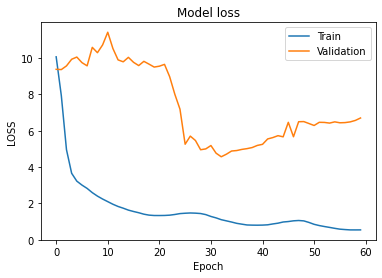

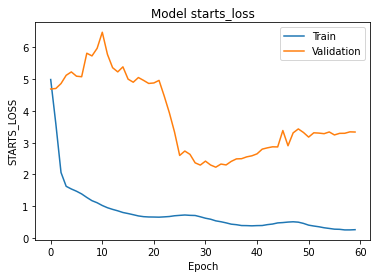

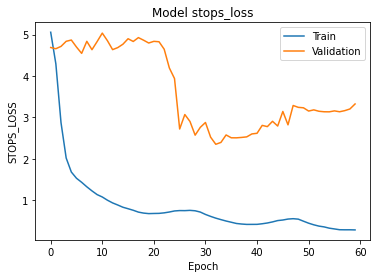

In [53]:
#metric_names = ['loss' ,'accuracy']
metric_names = ["loss", "starts_loss", "stops_loss"]

for i, j in zip(metric_names, ['val_'+i for i in metric_names]):
    plt.plot(history.history[i])
    plt.plot(history.history[j])
    plt.title('Model '+i)
    plt.ylabel(i.upper())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

## Validation

#### Inference

In [54]:
from tensorflow.keras.models import load_model

model = tf.keras.models.load_model(
    filepath="../results/"+MODEL_PREFIX+"Checkpoint.h5",
    compile=True
)

In [56]:
model.evaluate(x = {"att_flags":X_att_val, "words":X_val},
               y={"starts":Y_starts_val.argmax(axis=1), "stops":Y_stops_val.argmax(axis=1)},
               batch_size=PREDICT_BATCH_SIZE)

5201/5201 [==============================] - 1s 182us/sample - loss: 4.5657 - starts_loss: 2.1875 - stops_loss: 2.3699


[4.565717438142406, 2.1874716, 2.3699043]

In [57]:
pred_train = model.predict(x = {"att_flags":X_att_train, "words":X_train},
                           batch_size=PREDICT_BATCH_SIZE)
pred_val = model.predict(x = {"att_flags":X_att_val, "words":X_val},
                         batch_size=PREDICT_BATCH_SIZE)
pred_test = model.predict(x = {"att_flags":X_att_test, "words":X_test},
                          batch_size=PREDICT_BATCH_SIZE)

In [58]:
pred_starts_train, pred_stops_train = pred_train[0], pred_train[1]
pred_starts_val, pred_stops_val = pred_val[0], pred_val[1]
pred_starts_test, pred_stops_test = pred_test[0], pred_test[1]

In [59]:
print(pred_starts_train.shape, pred_stops_train.shape)
print(pred_starts_val.shape, pred_stops_val.shape)
print(pred_starts_test.shape, pred_stops_test.shape)

(20803, 110) (20803, 110)
(5201, 110) (5201, 110)
(3534, 110) (3534, 110)


In [60]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

In [61]:
preds = {
    "train":{
        "starts":{
            "y_true":Y_starts_train.argmax(axis=1),
            "y_pred":pred_starts_train.argmax(axis=1)
        },
        "stops":{
            "y_true":Y_stops_train.argmax(axis=1),
            "y_pred":pred_stops_train.argmax(axis=1)
        }
    },
    "valid":{
        "starts":{
            "y_true":Y_starts_val.argmax(axis=1),
            "y_pred":pred_starts_val.argmax(axis=1)
        },
        "stops":{
            "y_true":Y_stops_train.argmax(axis=1),
            "y_pred":pred_stops_train.argmax(axis=1)
        }        
    }
}

In [63]:
def print_metrics():
    funcs = [accuracy_score, f1_score, precision_score, recall_score, confusion_matrix]
    for f in funcs:
        for data_set in ["train","valid"]:
            for var in ["starts", "stops"]:
                if f in [accuracy_score]:
                    res = f(**preds[data_set][var])
                    print("{:.2f}".format(100 * res), "\t||", data_set, "\t||", var, "\t||", f.__name__)
                elif f in [confusion_matrix]:
                    res = f(**preds[data_set][var], labels = np.arange(max_len))
                    np.savetxt(X=res, fmt='%i', delimiter=",",
                               fname="../results/ConfusionMatrix_"+MODEL_PREFIX+"_"+data_set+"_"+var+".csv")
                    print("\t||", data_set, "\t||", var, "\t||", f.__name__, "\t||", 
                          "../results/ConfusionMatrix_"+MODEL_PREFIX+"_"+data_set+"_"+var+".csv")
                else:
                    res = f(**preds[data_set][var], average="macro")
                    print("{:.2f}".format(100 * res), "\t||", data_set, "\t||", var, "\t||", f.__name__)
        print("================================================================")

print_metrics()

84.24 	|| train 	|| starts 	|| accuracy_score
80.63 	|| train 	|| stops 	|| accuracy_score
56.51 	|| valid 	|| starts 	|| accuracy_score
80.63 	|| valid 	|| stops 	|| accuracy_score
59.19 	|| train 	|| starts 	|| f1_score
85.76 	|| train 	|| stops 	|| f1_score
9.17 	|| valid 	|| starts 	|| f1_score
85.76 	|| valid 	|| stops 	|| f1_score
71.65 	|| train 	|| starts 	|| precision_score
89.10 	|| train 	|| stops 	|| precision_score
10.03 	|| valid 	|| starts 	|| precision_score
89.10 	|| valid 	|| stops 	|| precision_score
56.30 	|| train 	|| starts 	|| recall_score
83.94 	|| train 	|| stops 	|| recall_score
9.14 	|| valid 	|| starts 	|| recall_score
83.94 	|| valid 	|| stops 	|| recall_score
	|| train 	|| starts 	|| confusion_matrix 	|| ../results/ConfusionMatrix_V09_train_starts.csv
	|| train 	|| stops 	|| confusion_matrix 	|| ../results/ConfusionMatrix_V09_train_stops.csv
	|| valid 	|| starts 	|| confusion_matrix 	|| ../results/ConfusionMatrix_V09_valid_starts.csv
	|| valid 	|| stops 	|

#### Postprocessing

In [ ]:
sent_labels = {i:j for i,j in enumerate(df.sentiment_code.cat.categories)}

In [ ]:
pred_train_words = [i[j>0.5].tolist() for i,j in zip(X_train, pred_train)]
pred_val_words = [i[j>0.5].tolist() for i,j in zip(X_val, pred_val)]
pred_test_words = [i[j>0.5].tolist() for i,j in zip(X_test, pred_test)]

#### Spot Checks

In [ ]:
def spot_check(index_to_check, mode):
    print("================== Sample #", index_to_check, "==================")
    if mode == "train":
        print("Sentiment:")
        print('\t', sent_labels[X_sentiments_train[index_to_check]])
        print("Selected_text:")
        print('\t', Y_words[train_idx[index_to_check]])
        print("Predicted_text:")
        print('\t', [get_from_vocab(vocab_itos,j) for j in pred_train_words[index_to_check]])
        print("Predictions:")
        print('\t',*[["%.2f"%j,
                      i,
                      X_words[train_idx[index_to_check]][num]] for num, (i,j) in enumerate(zip(X_train[index_to_check].tolist(),
                                                                                               pred_train[index_to_check].tolist())) if i!=0], sep="\n\t")
        
    elif mode == "validation":
        print("Sentiment:")
        print('\t', sent_labels[X_sentiments_val[index_to_check]])
        print("Selected_text:")
        print('\t', Y_words[val_idx[index_to_check]])
        print("Predicted_text:")
        print('\t', [get_from_vocab(vocab_itos,j) for j in pred_val_words[index_to_check]])
        print("Predictions:")
        print('\t',*[["%.2f"%j,
                      i,
                      X_words[val_idx[index_to_check]][num]] for num, (i,j) in enumerate(zip(X_val[index_to_check].tolist(),
                                                                                             pred_val[index_to_check].tolist())) if i!=0], sep="\n\t")
        
    else:
        print("Sentiment:")
        print('\t', sent_labels[X_sentiments_test[index_to_check]])
        print("Selected_text:")
        print('\t', "Not Available")
        print("Predicted_text:")
        print('\t', [get_from_vocab(vocab_itos,j) for j in pred_test_words[index_to_check]])
        print("Predictions:")
        print('\t',*[["%.2f"%j,
                      i,
                      X_test_words[index_to_check][num]] for num, (i,j) in enumerate(zip(X_test[index_to_check].tolist(),
                                                                                         pred_test[index_to_check].tolist())) if i!=0], sep="\n\t")

In [ ]:
for i in range(10,20):
    spot_check(i, mode="train")

In [ ]:
for i in range(200,210):
    spot_check(i, mode="validation")

In [ ]:
for i in range(10,20):
    spot_check(i, mode="test")

In [ ]:
def jaccard(str1, str2): 
    a = set(str1) 
    b = set(str2)
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
print("Training Jaccard Score", np.mean([jaccard(str1=i[i>0], str2=j) for i,j in zip(Y_train,pred_train_words)]))
print("Validation Jaccard Score", np.mean([jaccard(str1=i[i>0], str2=j) for i,j in zip(Y_val,pred_val_words)]))

In [ ]:
# Average number of words in selected text?
pd.Series([len(i) for i in Y]).describe()

In [ ]:
# is it generally predicting words that are in itself??
np.mean([sum([1  if (k in j) else 0 for k in i])/len(i) if len(i)!=0 else 0 for i,j in zip(pred_val_words, Y_val)])

In [ ]:
[(sent_labels[X_sentiments_test[num]], [get_from_vocab(vocab_itos,j) for j in i]) for num, i in enumerate(pred_test_words[:5])]

In [ ]:
def post_process(x):
    x = "".join(x)
    x = re.sub(pattern="xxxSTART", repl="", string=x)
    x = re.sub(pattern="xxxEND", repl="", string=x)
    return x

In [ ]:
pred_train_words = [[get_from_vocab(vocab_itos,j) for j in i] for i in pred_train_words]
pred_val_words = [[get_from_vocab(vocab_itos,j) for j in i] for i in pred_val_words]
pred_test_words = [[get_from_vocab(vocab_itos,j) for j in i] for i in pred_test_words]

In [ ]:
a = pred_val_words[300]
print([vocab_itos[i] for i in X_val[300] if i!=0])
print([vocab_itos[i] for i in Y_val[300] if i!=0])
print(pred_val_words[300])
print(post_process(a))

In [ ]:
post_process(pred_test_words[18])

In [ ]:
[[post_process(i)] for num, i in enumerate(pred_test_words)]

In [ ]:
from sklearn.metrics import jaccard_score

In [ ]:
def jaccard(str1, str2):
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
len(train_idx), keep_x_train.shape, pred_train.shape

In [ ]:
predictions = pd.DataFrame({
    "pred_selected_text" : pred_train_words + pred_val_words,
    "original_index" : np.concatenate((np.array(train_idx, dtype=np.int64)[keep_x_train],
                                       np.array(val_idx, dtype=np.int64)[keep_x_val])),
    "set" : ["train" for i in range(sum(keep_x_train))] + ["val" for i in range(sum(keep_x_val))]
})

In [ ]:
assert (predictions.original_index.min(), predictions.original_index.max()) == (df.original_index.min(), df.original_index.max())

In [ ]:
print(df.shape, predictions.shape)
results = pd.merge(df, predictions, on = "original_index", how="inner")
print(df.shape, predictions.shape, results.shape)

In [ ]:
results.loc[results.set=="val"].head(10)

In [ ]:
results.loc[results.set=="train"].head(10)

In [ ]:
conf_mat_train = confusion_matrix(Y_train.argmax(axis=1).reshape(-1), pred_train.reshape(-1))
conf_mat_val = confusion_matrix(Y_val.argmax(axis=1).reshape(-1), pred_val.reshape(-1))
print("The train accuracy is\t",np.round(100 * np.sum(np.diag(conf_mat_train)) / np.sum(conf_mat_train),2))
print("The valid accuracy is\t",np.round(100 * np.sum(np.diag(conf_mat_val)) / np.sum(conf_mat_val),2))

np.savetxt(X=conf_mat_train, fname="../results/ConfMatrix_train_" + MODEL_PREFIX + ".txt")
np.savetxt(X=conf_mat_val, fname="../results/ConfMatrix_val_" + MODEL_PREFIX + ".txt")

f1_train = f1_score(Y_train.argmax(axis=1).reshape(-1), pred_train.reshape(-1), average='macro')
f1_val = f1_score(Y_val.argmax(axis=1).reshape(-1), pred_val.reshape(-1), average='macro')
print("The train macro f1score is\t",np.round(f1_train,2))
print("The valid macro f1score is\t",np.round(f1_val,2))

In [ ]:
submission = pd.DataFrame({'time':test_df['time'],'open_channels':pred_test.reshape(-1)})
submission.to_csv("../results/submission_20200412V"+MODEL_NUMBER+".csv", index=False, float_format='%.4f')

In [ ]:
from tensorflow.keras.models import load_model

best_model = tf.keras.models.load_model(
    filepath="../results/"+MODEL_PREFIX+"Checkpoint.h5",
    compile=True,
    custom_objects = {'macro_soft_f1':macro_soft_f1, 'macro_f1':macro_f1}
)

In [ ]:
pred_train = best_model.predict(x = X_train, batch_size=PREDICT_BATCH_SIZE)
pred_val = best_model.predict(x = X_val, batch_size=PREDICT_BATCH_SIZE)
pred_test = best_model.predict(x = X_test, batch_size=PREDICT_BATCH_SIZE)

In [ ]:
pred_train = pred_train.argmax(axis=1)
pred_val = pred_val.argmax(axis=1)
pred_test = pred_test.argmax(axis=1)

In [ ]:
conf_mat_train = confusion_matrix(Y_train.argmax(axis=1).reshape(-1), pred_train.reshape(-1))
conf_mat_val = confusion_matrix(Y_val.argmax(axis=1).reshape(-1), pred_val.reshape(-1))

print("The train accuracy is\t",np.round(100 * np.sum(np.diag(conf_mat_train)) / np.sum(conf_mat_train),2))
print("The valid accuracy is\t",np.round(100 * np.sum(np.diag(conf_mat_val)) / np.sum(conf_mat_val),2))

np.savetxt(X=conf_mat_train, fname="../results/BestConfMatrix_train_" + MODEL_PREFIX + ".txt")
np.savetxt(X=conf_mat_val, fname="../results/BestConfMatrix_val_" + MODEL_PREFIX + ".txt")

f1_train = f1_score(Y_train.argmax(axis=1).reshape(-1), pred_train.reshape(-1), average='macro')
f1_val = f1_score(Y_train.argmax(axis=1).reshape(-1), pred_train.reshape(-1), average='macro')
print("The train macro f1score is\t",np.round(f1_train,2))
print("The valid macro f1score is\t",np.round(f1_val,2))

In [ ]:
submission = pd.DataFrame({'time':test_df['time'],'open_channels':pred_test.reshape(-1)})
submission.to_csv("../results/best_submission_20200412V"+MODEL_NUMBER+".csv", index=False, float_format='%.4f')